### About 
This notebooks trains object detector with MobileNetV3 + UNet structure on the full MaSTr dataset. This notebook trains a model with 3 classes, and does not include the boundary class. Input images are 224x224x3

The networks trained using this notebook's workflow are iteration 2 and iteration 3.


```
Dataset   : 'mastr.zip' 
                1325 images 

Labels
  Obstacles and environment = 0
  Water = 1
  Sky = 2
  Ignore region / unknown category = 4

X: ? x 384 x 512 x 3 .png files
y: ? x 384 x 512     .png files 
```

Files from this notebook are saved as:

Weights: `SNet_baseline_0e.zip`
Results: `results_SNet_baseline_0e.zip`

*Note that this notebook only runs on Google Colab with permission to the datasets.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports & Installs 


In [ ]:
# Install tfds-nightly for upsampling layer
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
# Install tfa for transformations
!pip install -q -U tensorflow-addons


     |████████████████████████████████| 3.9MB 8.8MB/s 
     |████████████████████████████████| 706kB 8.2MB/s 


In [ ]:
import os
import re
import random
import time
import math
import datetime

import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

from PIL import Image as pimage 
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm.notebook import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load data from google drive

**MasTr Dataset**

In [ ]:
if 'data' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
  !unzip -q 'mastr.zip' -d data
  !rm 'mastr.zip'

```
data
  - masks
  - images

Image names: 
  0001.jpg
  384 x 512 x 3
Annotation image names: 
  0001m.png
  384 x 512 x 1 (0: obstacle, 1: water, 2: sky)
```



**MODD2 Dataset**

In [ ]:
# Footage 1 to 28, used to export prediction & evaluate in MATLAB
if 'eval_data' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/eval_data_highres.zip" .
  !unzip -q 'eval_data_highres.zip' -d eval_data
  !rm 'eval_data_highres.zip'


```
eval_data
  - images
  - masks
 
Image names: 
  27_001.jpg 
  128 x 128 x 3
Annotation image names: 
  27_001m.png
  128 x 128 x 1 (background-pixel = 0, sea-pixel = 1)
```



### Dataset Pipeline - functions

1. `list_files`: get file names from directory 
2. `parse_image` : loads image & its corresponding label 
3. `load_image_train` and `load_image_test`: augmentation & normalize
4. `configure_ds`: cache, batch, and prefetch



In [ ]:
def parse_image(img_path: str) -> dict:
    '''
    Loads the image and its mask, returns a dictionary

    Original      Returns
    0: obstacle   0: obstacle
    1: water      1: water
    2: sky        2: sky
    4: unknown    3: unknown

    Args
    ----------
    img_path : str
        Image filename pattern (glob)
        (Mask location is found using regex)

    Returns
    ----------
    dict {'image': tensor (384 x 512 x 3), 'mask': tensor (384 x 512 x 3)}
        Dictionary mapping an image and its annotation.
    '''
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.dtypes.uint8)

    # For one Image path:
    # .../data/images/train/01_001.png
    # Its corresponding annotation path is:
    # .../data/annotations/train/01_001_label.png
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", "m.png")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1, dtype=tf.dtypes.uint8) #+ 1
    mask = tf.where(mask == 4, np.dtype('uint8').type(3), mask)
    # mask = tf.where(mask == 5, float(nan), mask )

    return {'image': image, 'mask': mask}

In [ ]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    '''
    Rescale the pixel values of the images from [0, 255] to [0, 1]

    Args
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [384,512,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [384,512,1].

    Returns
    ----------
    tuple
        Normalized image and its annotation.
    '''

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask


In [ ]:
def load_image_train(datapoint: dict) -> tuple:
    '''
    Apply some transformations to an input dictionary
    containing an image and its annotation.

    Note: should be applying to training set only

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A modified image and its annotation.
    '''

    input_image = datapoint['image']
    input_mask = datapoint['mask']
    height, width = 384, 512

    # Flip
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
    
    # Hue
    if tf.random.uniform(()) > 0.2:
      input_image = tf.image.random_hue(input_image, 0.2)
      input_image = tf.image.random_saturation(input_image, 0.8, 1.2)
      input_image = tf.image.random_contrast(input_image, 0.6, 1.4)
      input_image = tf.image.random_brightness(input_image, 0.2)

    # Rotation
    if tf.random.uniform(()) > 0.2:
      alpha = tf.random.uniform((), -math.pi/8, math.pi/8)
      input_image = tfa.image.rotate(tf.cast(input_image, dtype=tf.int32), alpha)
      input_mask = tfa.image.rotate(tf.cast(input_mask, dtype=tf.int32), alpha, fill_value=3)
      input_image = tf.cast(input_image, dtype=tf.uint8)
      input_mask = tf.cast(input_mask, dtype=tf.uint8)

    # Scaling
    if tf.random.uniform(()) > 0.2:
      crop_width = tf.random.uniform(shape=(), minval=math.floor(0.7 * width), maxval=math.floor(0.9 * width), dtype = tf.int32)
      crop_height = tf.random.uniform(shape=(), minval=math.floor(0.7 * height), maxval=math.floor(0.9 * height), dtype = tf.int32)

      offset_x = tf.random.uniform(shape=(), minval=0, maxval=(width - crop_width), dtype = tf.int32)
      offset_y = tf.random.uniform(shape=(), minval=0, maxval=(height - crop_height), dtype = tf.int32)

      input_image = tf.image.crop_to_bounding_box(input_image, offset_y, offset_x, crop_height, crop_width)
      input_mask = tf.image.crop_to_bounding_box(input_mask, offset_y, offset_x, crop_height, crop_width)

    # Resize
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    # Normalize & clip
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.clip_by_value(input_image, clip_value_min=0., clip_value_max=1.)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint: dict) -> tuple:
    '''
    Normalize and resize a test image and its annotation, no augmentation

    Note: 
      Applies to both validation and testing set

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    '''

    # input_image = datapoint['image']
    # input_mask = datapoint['mask']

    # Resize
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['mask'], (IMG_SIZE, IMG_SIZE))

    # Normalize
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### Dataset Pipeline - execute

In [ ]:
IMG_SIZE = 224
# Batch size is set to 32 in order to see if inference at real time is possible
BATCH_SIZE = 64
N_CLASSES = 3         # 0: obstacle, 1: water, 2: sky
TRAIN_VAL_RATIO = 0.90 # Within the MasTr dataset


# For reproducible result 
SEED = 321
# tf.random.set_seed(SEED)

In [ ]:
data_dir = os.path.join(os.getcwd(), 'data/')
images_path = os.path.join(os.getcwd(), 'data/images/')
labels_path = os.path.join(os.getcwd(), 'data/masks/')

test_data_dir = os.path.join(os.getcwd(), 'data/')
test_images_path = os.path.join(os.getcwd(), 'test_data/images/')
test_labels_path = os.path.join(os.getcwd(), 'test_data/masks/')

eval_data_dir = os.path.join(os.getcwd(), 'eval_data/')
eval_images_path = os.path.join(os.getcwd(), 'eval_data/images/')
eval_labels_path = os.path.join(os.getcwd(), 'eval_data/masks/')

total_image_count = len(os.listdir(images_path))

print('total number of images:      {}'.format(total_image_count))

total number of images:      1325


In [ ]:
# Get list of all image files
list_dir = tf.data.Dataset.list_files(images_path + '*.jpg', shuffle=True, seed=SEED)
# test_ds = tf.data.Dataset.list_files(test_images_path + '*.jpg', shuffle=False)

test_sequence_folders = ['seq27', 'seq28']
eval_ds = tf.data.Dataset.list_files(eval_images_path + 'seq*' + '/*.jpg', shuffle=False) 
test_ds = tf.data.Dataset.list_files([eval_images_path + seq + '/*.jpg' for seq in test_sequence_folders], shuffle=False) 

# # Get list of file names for train and val
train_length = round(total_image_count * TRAIN_VAL_RATIO)
train_ds = list_dir.take(train_length)
val_ds = list_dir.skip(train_length)

# Get length of each dataset
TRAINSET_SIZE = tf.data.experimental.cardinality(train_ds).numpy()
VALSET_SIZE = tf.data.experimental.cardinality(val_ds).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_ds).numpy()
EVAL_SIZE = tf.data.experimental.cardinality(eval_ds).numpy()

print(f'Train: {TRAINSET_SIZE}, Val: {VALSET_SIZE}, Test: {TEST_SIZE}, Eval: {EVAL_SIZE}')

Train: 1192, Val: 133, Test: 1292, Eval: 11703


In [ ]:
train_ds = train_ds.map(parse_image)
val_ds = val_ds.map(parse_image)
test_ds = test_ds.map(parse_image)
eval_ds = eval_ds.map(parse_image)

In [ ]:
# Training set:
#           cache -> shuffle -> Augment -> batch -> repeat -> prefetch

# Validation set:
# Resize -> cache -> shuffle -> batch ->                      prefetch

# Test & Eval set:
# Resize -> batch

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(load_image_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_image_test, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(load_image_test, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size = BATCH_SIZE)
# runtime_test_ds = test_ds.cache().batch(batch_size=TEST_SIZE)

eval_ds = eval_ds.map(load_image_test, num_parallel_calls=AUTOTUNE)
eval_ds = eval_ds.batch(batch_size = BATCH_SIZE)

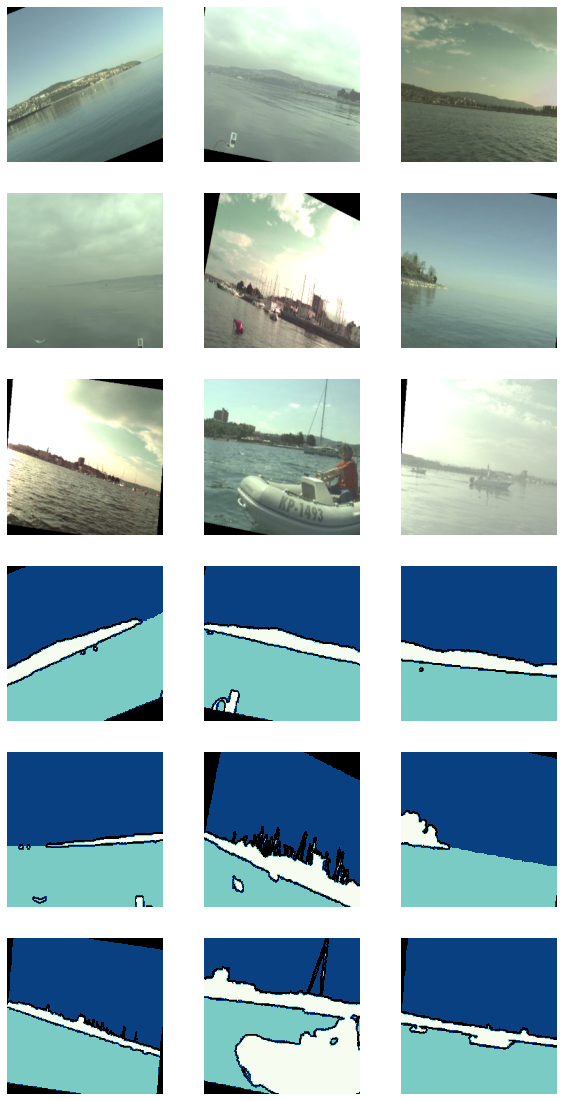

In [ ]:
### Display images

# train_ds.skip(37)
for image_batch, mask_batch in train_ds.take(1):
  plt.figure(figsize=(10, 20))
  for i in range(9):
    ax = plt.subplot(6, 3, i + 1)
    image = image_batch[i]
    mask = mask_batch[i]
    plt.imshow(image)
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(mask), alpha=0.3, cmap='GnBu')
    plt.axis("off")
  for i in range(9):
    ax = plt.subplot(6, 3, i + 1+9)
    image = image_batch[i]
    mask = mask_batch[i]
    # plt.imshow(image)
    plt.imshow(mask.numpy().squeeze(), alpha=1, cmap=custom_cmap, norm=norm)
    plt.axis("off")
  break
# i = 0
# display([image_batch[i], mask_batch[i]])

In [ ]:
custom_cmap = colors.ListedColormap(['#F7FCF0','#7ACBC4','#084081', 'black'])
boundaries = np.array([-1, 0, 1, 2, 5])+0.01
norm = colors.BoundaryNorm(boundaries, custom_cmap.N)

height, width = 224, 224
index = 6
for image_batch, mask_batch in val_ds.take(1):
  input_image, input_mask = image_batch[index], mask_batch[index]
  input_image = tf.cast(input_image*255, tf.uint8)

original_image, original_mask = input_image, input_mask

input_image = tf.image.flip_left_right(input_image)
input_mask = tf.image.flip_left_right(input_mask)

image_reflect, mask_reflect = input_image, input_mask

alpha = math.pi/16
input_image = tfa.image.rotate(tf.cast(input_image, dtype=tf.int32), alpha)
input_mask = tfa.image.rotate(tf.cast(input_mask, dtype=tf.int32), alpha, fill_value=3)
input_image = tf.cast(input_image, dtype=tf.uint8)
input_mask = tf.cast(input_mask, dtype=tf.uint8)

image_rotate, mask_rotate = input_image, input_mask

crop_width = tf.random.uniform(shape=(), minval=math.floor(0.7 * width), maxval=math.floor(0.71 * width), dtype = tf.int32)
crop_height = tf.random.uniform(shape=(), minval=math.floor(0.7 * height), maxval=math.floor(0.71 * height), dtype = tf.int32)
offset_x = tf.random.uniform(shape=(), minval=0, maxval=(width - crop_width), dtype = tf.int32)
offset_y = tf.random.uniform(shape=(), minval=0, maxval=(height - crop_height), dtype = tf.int32)
input_image = tf.image.crop_to_bounding_box(input_image, offset_y, offset_x, crop_height, crop_width)
input_mask = tf.image.crop_to_bounding_box(input_mask, offset_y, offset_x, crop_height, crop_width)

image_scale, mask_scale = input_image, input_mask

input_image = tf.image.random_hue(input_image, 0.2)
input_image = tf.image.random_saturation(input_image, 0.8, 1.2)
input_image = tf.image.random_contrast(input_image, 0.6, 1.4)
input_image = tf.image.random_brightness(input_image, 0.2)

image_hue, mask_hue = input_image, input_mask

image_list = [original_image, image_reflect, image_rotate, image_scale, image_hue]
mask_list = [original_mask, mask_reflect, mask_rotate, mask_scale, mask_hue]

plt.figure(figsize=(20, 8))

for i, (image, mask) in enumerate(zip(image_list, mask_list)):
  plt.subplot(2, 5, i+1)
  plt.imshow(image)
  plt.axis('off')
  plt.subplot(2, 5, i+1+5)
  plt.imshow(mask.numpy().squeeze(), alpha=1, cmap=custom_cmap, norm=norm)
  plt.axis('off')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.05,  hspace=0.05)
plt.show()

### Model Definition

In [ ]:
tf.keras.backend.clear_session()

# Encoder
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=[224, 224, 3], include_top=False, weights='imagenet')
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Extract the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64 x 64 x 96
    'block_3_expand_relu',   # 32 x 32 x 144
    'block_6_expand_relu',   # 16 x 16 x 192
    'block_13_expand_relu',  # 8  x 8  x 576
    'block_16_project',      # 4  x 4  x 320
]

layers = [base_model.get_layer(name).output for name in layer_names]

# # Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
def deconv_block(filters, size, norm_type='batchnorm', dropout_rate = 0.5):
  '''
  Conv2DTranspose => Batchnorm => Dropout => Relu
  '''
  initializer = tf.random_normal_initializer(0., 0.02)
  # tf.keras.initializers.GlorotNormal()
  # tf.keras.initializers.HeNormal(seed=None)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                      use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  # result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
# Decoder
up_stack = [
    deconv_block(512, 3, dropout_rate = 0.5),  # 4x4 -> 8x8
    deconv_block(256, 3, dropout_rate = 0.4),  # 8x8 -> 16x16
    deconv_block(128, 3, dropout_rate = 0.3),  # 16x16 -> 32x32
    deconv_block(64, 3, dropout_rate = 0.2),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  ''' Instantiate a new instance of UNet Model '''
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Visualisation functions

In [ ]:
def create_mask(pred_mask):
  ''' Finds top prediction mask and returns it'''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def display(display_list, merge = False):
  '''
  Takes an array of images and plots them

  Args
  ----------
  display_list: list
    expecting [input, true mask, predicted mask]

  Returns
  ----------
  None, graph is displayed
  '''
  if not merge:

    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      # plt.title(title[i])
      displayed_image = display_list[i]
      if (display_list[i].shape[-1] == 1):
        displayed_image = display_list[i].numpy().squeeze()
      plt.imshow(displayed_image, cmap=custom_cmap, norm=norm)
      plt.axis('off')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.05,  hspace=0.05)
    plt.show()

  elif merge == True:
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[1]), alpha = 0.5)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[2]), alpha = 0.5)
    plt.axis('off')

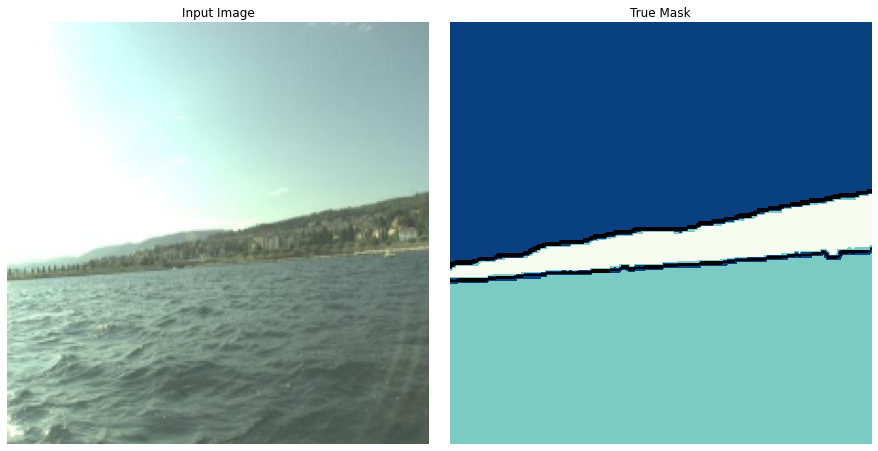

In [ ]:
def show_predictions(dataset=None, num=1, show_sample=False, merge=False):
  '''
  For a given dataset plots one image, its true mask, and predicted mask

  Args
  ----------
  dataset (optional): tf.dataset object, defaults first image in testing set
  num (optional): int
  sample (optional): bool: if True, display prediction for sample image

  Returns
  ----------
  Nothing, graph will be displayed

  '''
  batches = num//BATCH_SIZE + 1
  remainder = num%BATCH_SIZE
  if show_sample:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], merge=merge) 
    return
  if dataset:
    for image, mask in dataset.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)
  else:
    for image, mask in test_ds.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)

for images, masks in val_ds.take(1):
  sample_image, sample_mask = images[5], masks[5] 

display([sample_image, sample_mask])

### Shoreline Eval functions

In [ ]:
def MODD2_shoreline_eval_single_image(gt_mask, pred_mask):

  '''
  Calculates the RMSE of horizon detection for a single image

  Args:
  ---------
  gt_mask: numpy.array (128, 128, 1)
  pred_mask: numpy.array (128, 128, 1)

  Returns:
  --------
  rmse: int
    (normalized) root mean square error of a single image
  '''

  HEIGHT = len(gt_mask)
  WIDTH = len(gt_mask[0, :])
  gt_len = 1

  diffs = np.empty(WIDTH)
  for i in range(WIDTH):
    # print(gt_mask[:, i])
    # print(pred_mask[:, i])
    for j, val in enumerate(gt_mask[:, i]):
      if val == 1:
        gt_len += 1
        break
    for k, val in enumerate(pred_mask[:, i]):
      if val == 1:
        break
    # if no detection along column, assume detection is at bottom of the image
    diffs[i] = abs(j - k)/HEIGHT
    # overflow occurs because of np division, shouldn't affect performance
    rmse = np.sqrt((sum(diffs)**2))/gt_len
  return rmse

# tic = time.perf_counter()
# gt_mask = sample_mask.numpy()
# pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...])).numpy()
# toc = time.perf_counter()
# print(f"preparing: {toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# MODD2_shoreline_eval_single_image(gt_mask, pred_mask)
# toc = time.perf_counter()
# print(f"RMSE: {toc - tic:0.4f} seconds")

In [ ]:
def MODD2_shoreline_eval(ds='test'):
  '''
  Returns score for the MODD2 evaluation of shoreline

  From MODD2 github page:
    For each pixel column in the full-sized image, a distance between water edge, 
    as given by the ground truth and as determined by the algorithm, is calculated. 
    These values are summarised into a single value by averaging across all 
    columns, frames and sequences.

  Args: 
  ----------
  ds: tf.dataset
    dataset object (either train_ds, val_ds, or test_ds)

  Returns:
  ----------
  (mean, std): tuple
    the mean and std for difference between prediction and gt
  '''
  if ds == 'test':
    ds_length = TEST_SIZE
    ds = test_ds
  elif ds == 'train':
    ds_length = TRAINSET_SIZE
    ds = train_ds
  elif ds == 'val':
    ds_length = VALSET_SIZE
    ds = val_ds
  elif ds == 'eval':
    ds_length = EVAL_SIZE
    ds = eval_ds
  else:
    print('Please input valid dataset name (either train, val, or test)')
    raise ValueError()

  num_batches = ds_length // BATCH_SIZE + 1

  # Loop through batches
  RMSEs = []
  for images, labels in tqdm(ds.take(num_batches)):
    preds = model.predict(images)
    # Loop through images within a batch:
    for i, label in enumerate(labels):
      # Have to convert to numpy, iterating through tensor is very slow
      gt_label = label.numpy()
      pred_label = create_mask(preds[i][tf.newaxis, ...]).numpy()

      RMSE = MODD2_shoreline_eval_single_image(gt_label, pred_label)
      RMSEs.append(RMSE)
  return RMSEs

### Training

**Custom loss function**

In the MasTr dataset, the edges of regions are labelled with class 4. The researchers took these regions as 'ambiguous' regions and ignore it. 

The loss function therefore need to ignore the pixels containing class 4

Problem: losing a lot of pixels 

In [ ]:
UNLABELLED = 3.0

def custom_SparseCategoricalCrossentropy(y_true, y_pred):
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
  y_true = tf.boolean_mask(y_true, haslabel)
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True, axis=-1)


def custom_sigmoid_focal_crossentropy(y_true, y_pred):
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
  y_true = tf.boolean_mask(y_true, haslabel)
  y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, from_logits=True)

In [ ]:
def count_num_unlabelled():
  sum = 0
  for images, labels in val_ds.take(VALSET_SIZE//BATCH_SIZE+1):
    for image, y_true in zip(images, labels):
      y_true = y_true[tf.newaxis, ...]

      haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
      y_true = tf.boolean_mask(y_true, haslabel)
      y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
      sum += 1-len(y_true)/(224*224)
  return sum/VALSET_SIZE

1 - count_num_unlabelled()

0.9871265176653368

**Callbacks**

- `cp_callback`: saves the best checkpoint weight based on validation loss
- `tensorboard_callback`: writes results to tensorboard
- `rsme_callback`: computes rmse on eval and val set every 5 epochs, writes to tensorboard

In [ ]:
# TENSORBOARD CALLBACK
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
  os.mkdir(checkpoint_path)
except:
  pass

# CHECKPOINT CALLBACK
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'2',
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 monitor = 'val_accuracy',
                                                 verbose=1)

# RMSE CALLBACK
rmse_writer = tf.summary.create_file_writer(log_dir)

class RMSE_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
      if epoch%5 == 0:
        mean = np.mean(MODD2_shoreline_eval())
        mean_val = np.mean(MODD2_shoreline_eval('val'))
        with rmse_writer.as_default():
          tf.summary.scalar('RMSE_eval', mean, step=epoch)
          tf.summary.scalar('RMSE_val', mean_val, step=epoch)
        print('Test RMSE: {}'.format(mean))
        print('Val  RMSE: {}'.format(mean_val))

rmse_callback = RMSE_callback()

**Instantiate model or load model**

In [ ]:
# Retrieve model from drive to cwd 
retrieve_index = 'focal_dropout_400'
filename = 'SNet_' + retrieve_index + 'e.zip'
model_path = '/content/drive/MyDrive/project_online/saved_models/' + filename
!unzip '$model_path' -d 'trained_model'

model = tf.keras.models.load_model('/content/trained_model/SNet_focal_dropout_400e', custom_objects={'custom_sigmoid_focal_crossentropy': custom_sigmoid_focal_crossentropy})

model.save_weights(checkpoint_path+ retrieve_index + 'e')

In [ ]:
model = unet_model(output_channels=N_CLASSES)
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=custom_SparseCategoricalCrossentropy, #custom_sigmoid_focal_crossentropy,
              metrics=['accuracy'])

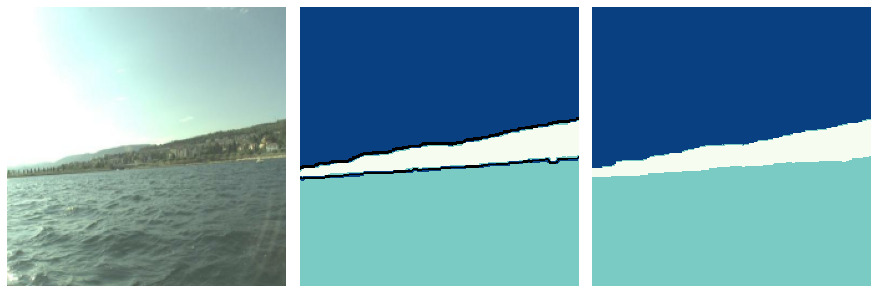

In [ ]:
# Check that everything is loaded properlly
show_predictions(show_sample=True)

In [ ]:
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history_2 = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[cp_callback, tensorboard_callback],
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds)

Epoch 1/200
18/18 [==============================] - 38s 2s/step - loss: 0.7924 - accuracy: 0.6324 - val_loss: 0.4188 - val_accuracy: 0.8595

Epoch 00001: val_accuracy improved from -inf to 0.85950, saving model to training_checkpoints/cp.ckpt2
Epoch 2/200
18/18 [==============================] - 24s 1s/step - loss: 0.2047 - accuracy: 0.9021 - val_loss: 0.2088 - val_accuracy: 0.9278

Epoch 00002: val_accuracy improved from 0.85950 to 0.92781, saving model to training_checkpoints/cp.ckpt2
Epoch 3/200
18/18 [==============================] - 25s 1s/step - loss: 0.1183 - accuracy: 0.9253 - val_loss: 0.2006 - val_accuracy: 0.9237

Epoch 00003: val_accuracy did not improve from 0.92781
Epoch 4/200
18/18 [==============================] - 26s 2s/step - loss: 0.0956 - accuracy: 0.9230 - val_loss: 0.0839 - val_accuracy: 0.9584

Epoch 00004: val_accuracy improved from 0.92781 to 0.95843, saving model to training_checkpoints/cp.ckpt2
Epoch 5/200
18/18 [==============================] - 26s 2s/st

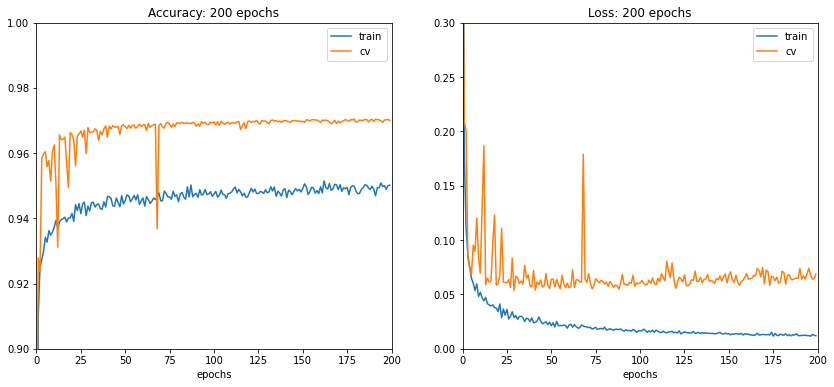

In [ ]:
def show_result_graphs(history):
  plt.figure(figsize=(14, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history['accuracy'], label='train')
  plt.plot(history['val_accuracy'], label='cv')
  plt.title(f'Accuracy: {200} epochs')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylim(0.90, 1)
  plt.xlim(0, 200)


  plt.subplot(1, 2, 2)
  plt.plot( history['loss'], label='train')
  plt.plot(history['val_loss'], label='cv')
  plt.title(f'Loss: {200} epochs')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylim(0, 0.3)
  plt.xlim(0, 200)
  plt.show()

show_result_graphs(model_history_2.history)


In [ ]:
model.save_weights(checkpoint_path+'600')

In [ ]:
# Load best model
# model.save_weights(checkpoint_path+'1300e')
model.load_weights(checkpoint_path+'2')

### Evaluate

In [ ]:
# Calculate RMSEs
RMSEs_test, RMSEs_val, RMSEs_train, RMSEs_eval = 0, 0, 0, 0

RMSEs_test = MODD2_shoreline_eval()

mean = np.mean(RMSEs_test)
std = np.std(RMSEs_test)
print(mean, std)
# 0.01879525364004115 0.025340108952624577. (0.013802) #1239 

# 200e: 1452
# 400e: 1346 
# 600e: 1483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.013679297572437164 0.015720921570939125


In [ ]:
# Calculate RMSEs
RMSEs_eval = MODD2_shoreline_eval('eval')

mean = np.mean(RMSEs_eval)
std = np.std(RMSEs_eval)
print(mean, std)
# 0.025352097800063183 0.031343618588398944

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.012836116223670943 0.013141670920133651


In [ ]:
RMSEs_val = MODD2_shoreline_eval('val')

mean = np.mean(RMSEs_val)
std = np.std(RMSEs_val)
print(mean, std)

# 0.01081862798777507 0.011286257064264645

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.005692742183430825 0.0035327649930063467


In [ ]:
RMSEs_train = MODD2_shoreline_eval('train')

mean = np.mean(RMSEs_train)
std = np.std(RMSEs_train)
print(mean, std)
# 0.010701362492558989 0.07869251732263077

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.01242483183755829 0.017122529007737915


### Score Summary


In [ ]:
list_summary = []

list_summary.append([TRAINSET_SIZE, np.mean(RMSEs_train), np.std(RMSEs_train), np.mean(RMSEs_train) * 958])
list_summary.append([VALSET_SIZE, np.mean(RMSEs_val), np.std(RMSEs_val), np.mean(RMSEs_val) * 958])
list_summary.append([TEST_SIZE, np.mean(RMSEs_test), np.std(RMSEs_test), np.mean(RMSEs_test) * 958])
list_summary.append([EVAL_SIZE, np.mean(RMSEs_eval), np.std(RMSEs_eval), np.mean(RMSEs_eval) * 958])


df_summary = pd.DataFrame(data=list_summary, columns=['no.imgs', 'mean', 'std', 'mean-px'], index=['train', 'val', 'test', 'eval'])

df_summary

,no.imgs,mean,std,mean-px
train,1192,0.012425,0.017123,11.902989
val,133,0.005693,0.003533,5.453647
test,1292,0.013679,0.015721,13.104767
eval,11703,0.000000,0.000000,0.000000


In [ ]:
# Test images
# 27_128 (reflection)         take(3)
# 27_256 (building)           take(5)
# 27_384 (big wall right)     take(7)
# 27_448 (big wall mid)       take(8)
# 27_512 (big wall left)      take(9)
# --------------------------- (total 671 images)
# 28_33 (standard)            take(12)
# 28_417 (wall mid)           take(18)
# 28_609 (hazy)               take(21)

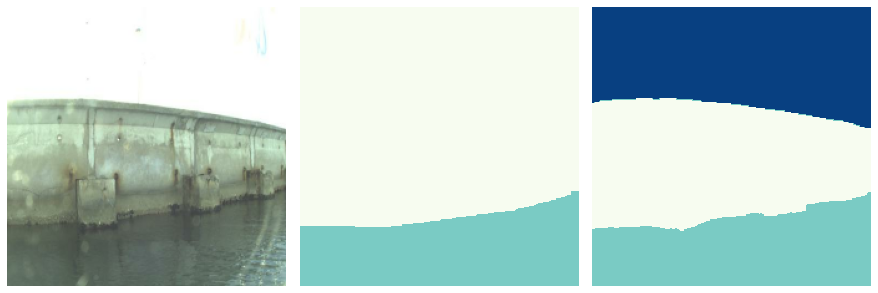

In [ ]:
index = 0

# test_ds.skip(6)
for image, mask in test_ds.take(18):
  display_image, display_mask = image[index], mask[index]

pred_mask = model.predict(display_image[tf.newaxis, ...])
pred_mask = create_mask(pred_mask)
display([display_image, display_mask, pred_mask])


### Export detection results




**Export Model Checkpoint**

In [ ]:
result_dir = '/content/results'
sequence_dirs = []

# Make folders
try:
  os.mkdir(os.path.join(os.getcwd(), 'results'))
  for i in range(28):
    sequence_dir = os.path.join(result_dir, f'seq{i+1:02d}')
    output_dir = os.path.join(sequence_dir, 'Unet')
    sequence_dirs.append(sequence_dir)
    os.mkdir(sequence_dir)
    os.mkdir(output_dir)
except:
  print('error raised')

In [ ]:
eval_dir = '/content/eval_data'
eval_image_dir = os.path.join(eval_dir, 'images')

for i in range(28):
  seq_foldername = f'seq{i+1:02d}'
  seq_filepath = os.path.join(eval_image_dir, seq_foldername)
  print(f'detecting results for {seq_foldername}...')
  for image in tqdm(sorted(os.listdir(seq_filepath))):
    if image.endswith('.jpg'):
      filename = image[:-4]
      filepath = os.path.join(seq_filepath, image)
      out_filename = filename + '_pred'
      out_filepath = os.path.join(result_dir, seq_foldername, out_filename + '.png')

      image = pimage.open(filepath)
      image = image.resize((224, 224))
      image_np = np.asarray(image)/255
      image_tensor = tf.convert_to_tensor(image_np)

      pred_mask = model.predict(image_tensor[tf.newaxis, ...])
      pred_mask = tf.squeeze(create_mask(pred_mask))
      
      pred_mask_np = pred_mask.numpy()
      pred_mask_np = np.repeat(np.expand_dims(pred_mask_np, axis=2), 3, axis=2)
      pred_mask_image = pimage.fromarray(pred_mask_np.astype(np.uint8), 'RGB')
      pred_mask_image = pred_mask_image.resize((512, 384))
      # print(out_filepath)
      pred_mask_image.save(out_filepath)

detecting results for seq01...



detecting results for seq02...



detecting results for seq03...



detecting results for seq04...



detecting results for seq05...



detecting results for seq06...



detecting results for seq07...



detecting results for seq08...



detecting results for seq09...



detecting results for seq10...



detecting results for seq11...



detecting results for seq12...



detecting results for seq13...



detecting results for seq14...



detecting results for seq15...



detecting results for seq16...



detecting results for seq17...



detecting results for seq18...



detecting results for seq19...



detecting results for seq20...



detecting results for seq21...



detecting results for seq22...



detecting results for seq23...



detecting results for seq24...



detecting results for seq25...



detecting results for seq26...



detecting results for seq27...



detecting results for seq28...


In [ ]:
# Zip and save to drive 
%%bash
cd results
zip -r 'Results_SNet_baseline_200e_gaussian.zip' . -x '.*' -x '__MACOSX'

  adding: seq10/ (stored 0%)
  adding: seq10/00011285L_pred.png (deflated 60%)
  adding: seq10/00011234L_pred.png (deflated 52%)
  adding: seq10/00011266L_pred.png (deflated 58%)
  adding: seq10/00011261L_pred.png (deflated 57%)
  adding: seq10/00011297L_pred.png (deflated 63%)
  adding: seq10/00011281L_pred.png (deflated 61%)
  adding: seq10/00011220L_pred.png (deflated 50%)
  adding: seq10/00011215L_pred.png (deflated 48%)
  adding: seq10/00011305L_pred.png (deflated 64%)
  adding: seq10/00011210L_pred.png (deflated 45%)
  adding: seq10/00011219L_pred.png (deflated 47%)
  adding: seq10/00011263L_pred.png (deflated 55%)
  adding: seq10/00011289L_pred.png (deflated 59%)
  adding: seq10/00011218L_pred.png (deflated 45%)
  adding: seq10/00011258L_pred.png (deflated 58%)
  adding: seq10/00011233L_pred.png (deflated 55%)
  adding: seq10/00011228L_pred.png (deflated 48%)
  adding: seq10/00011238L_pred.png (deflated 58%)
  adding: seq10/00011295L_pred.png (deflated 60%)
  adding: seq10/00011

In [ ]:
!cp 'results/Results_SNet_baseline_200e_gaussian.zip' '/content/drive/My Drive/project_online/'

## Export model

In [ ]:
out_filepath = 'SNet_baseline_600e'
out_zipfile = out_filepath + '.zip'

In [ ]:
model.save(filepath=out_filepath)

INFO:tensorflow:Assets written to: SNet_baseline_600e/assets


In [ ]:
out_filepath = 'SNet_baseline_600e'
out_zipfile = out_filepath + '.zip'
!zip -r '$out_zipfile' '$out_filepath' -x '.*' -x '__MACOSX'

  adding: SNet_baseline_600e/ (stored 0%)
  adding: SNet_baseline_600e/variables/ (stored 0%)
  adding: SNet_baseline_600e/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: SNet_baseline_600e/variables/variables.index (deflated 76%)
  adding: SNet_baseline_600e/saved_model.pb (deflated 92%)
  adding: SNet_baseline_600e/assets/ (stored 0%)


In [ ]:
out_zipfile = out_filepath + '.zip'
!cp '$out_zipfile'  '/content/drive/My Drive/project_online/saved_models'

In [ ]:
np.save(out_filepath+'.npy', model_history_2.history)
out_npfile = out_filepath + '.npy'

!cp '$out_npfile'  '/content/drive/My Drive/project_online/saved_models'